#  Recurrent PG Crypto-Currency Trading

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib.pylab import date2num
from HuobiServices import *
from DataUtils import *
import talib
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import os
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [343]:
lmap=lambda func,it: list(map(lambda x:func(x),it))
lfilter=lambda func,it: list(filter(lambda x:func(x),it))
z_score=lambda x:(x-np.mean(x,axis=0))/(np.std(x,axis=0)+1e-5)

In [3]:
def generate_tech_data_default(stock, open_name, close_name, high_name, low_name,volume_name='vol'):
    open_price = stock[open_name].values
    close_price = stock[close_name].values
    low_price = stock[low_name].values
    high_price = stock[high_name].values
    volume = stock[volume_name].values
    data = stock.copy()
    data['MOM'] = talib.MOM(close_price)
    data['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_price)
    data['HT_DCPHASE'] = talib.HT_DCPHASE(close_price)
    data['sine'], data['leadsine'] = talib.HT_SINE(close_price)
    data['inphase'], data['quadrature'] = talib.HT_PHASOR(close_price)
    data['ADXR'] = talib.ADXR(high_price, low_price, close_price)
    data['APO'] = talib.APO(close_price)
    data['AROON_UP'], _ = talib.AROON(high_price, low_price)
    data['CCI'] = talib.CCI(high_price, low_price,close_price)
    data['PLUS_DI'] = talib.PLUS_DI(high_price, low_price, close_price)
    data['PPO'] = talib.PPO(close_price)
    data['macd'], data['macd_sig'], data['macd_hist'] = talib.MACD(close_price)
    data['CMO'] = talib.CMO(close_price)
    data['ROCP'] = talib.ROCP(close_price)
    data['fastk'], data['fastd'] = talib.STOCHF(high_price, low_price, close_price)
    data['TRIX'] = talib.TRIX(close_price)
    data['ULTOSC'] = talib.ULTOSC(high_price, low_price, close_price)
    data['WILLR'] = talib.WILLR(high_price, low_price, close_price)
    data['NATR'] = talib.NATR(high_price, low_price, close_price)
    data['MFI']=talib.MFI(high_price,low_price,close_price,volume)
    data['RSI']=talib.RSI(close_price)
    data['AD']=talib.AD(high_price,low_price,close_price,volume)
    data['OBV']=talib.OBV(close_price,volume)
    data['EMA'] = talib.EMA(close_price)
    data['SAREXT'] = talib.SAREXT(high_price,low_price)
    data['TEMA'] = talib.EMA(close_price)
    data = data.drop([open_name, close_name, high_name, low_name,'amount','count'], axis=1)
    data = data.dropna().astype(np.float32)
    return data

In [292]:
class RPG_CryptoNG(object):
    def __init__(self, feature_number, action_size=1, hidden_units_number=[128, 64], learning_rate=0.001):
        tf.reset_default_graph()
        self.s = tf.placeholder(dtype=tf.float32, shape=[None,None, feature_number], name='s')
        self.a = tf.placeholder(dtype=tf.int32, shape=[None,None,action_size], name='a')
        self.r = tf.placeholder(dtype=tf.float32, shape=[None,None], name='r')
        self.s_next=tf.placeholder(dtype=tf.float32, shape=[None,None, feature_number], name='s_next')
        self.action_size=action_size
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32, shape=[], name='dropout_keep_prob')
        with tf.variable_scope('rnn_encoder', initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            cell=self._add_GRU(units_number=128,activation=tf.nn.tanh,keep_prob=self.dropout_keep_prob)
#             self.rnn_input=tf.expand_dims(self.s,axis=0)
            self.rnn_output,_=tf.nn.dynamic_rnn(inputs=self.s,cell=cell,dtype=tf.float32)
#             self.rnn_output=tf.unstack(self.rnn_output,axis=0)[0]
            
        with tf.variable_scope('supervised',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
            self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
            self.state_predict = self._add_dense_layer(inputs=self.rnn_output, output_shape=[feature_number], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.state_loss=tf.losses.mean_squared_error(self.state_predict,self.s_next)
            
        with tf.variable_scope('policy_gradient',initializer=tf.contrib.layers.xavier_initializer(uniform=True), regularizer=tf.contrib.layers.l2_regularizer(0.01)):
#             self.rnn_output=tf.stop_gradient(self.rnn_output)
            self.a_prob = self._add_dense_layer(inputs=self.rnn_output, output_shape=hidden_units_number, drop_keep_prob=self.dropout_keep_prob, act=tf.nn.relu, use_bias=True)
            self.a_prob = self._add_dense_layer(inputs=self.a_prob, output_shape=[action_size], drop_keep_prob=self.dropout_keep_prob, act=None, use_bias=True)
            self.a_out = tf.nn.softmax(self.a_prob,axis=-1)
            self.negative_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.a_prob, labels=self.a)
            
        with tf.variable_scope('train'):
            optimizer_rl = tf.train.AdamOptimizer(learning_rate=learning_rate)
            optimizer_sl = tf.train.AdamOptimizer(learning_rate=learning_rate*2)
            self.rlloss = tf.reduce_mean(self.negative_cross_entropy * self.r)
            self.slloss=tf.reduce_mean(self.state_loss)
            self.rltrain_op = optimizer_rl.minimize(self.rlloss)
            self.sltrain_op = optimizer_sl.minimize(self.slloss)
        self.init_op = tf.global_variables_initializer()
        self.session = tf.Session()
        self.saver = tf.train.Saver()
    def init_model(self):
        self.session.run(self.init_op)
    
    def _add_dense_layer(self, inputs, output_shape, drop_keep_prob, act=tf.nn.relu, use_bias=True):
        output = inputs
        for n in output_shape:
            output = tf.layers.dense(output, n, activation=act, use_bias=use_bias)
            output = tf.nn.dropout(output, drop_keep_prob)
        return output
    
    def _add_GRU(self,units_number,activation=tf.nn.relu,keep_prob=1.0):
        cell = tf.contrib.rnn.GRUCell(units_number,activation=activation)
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
        return cell
    
    def _add_GRUs(self,units_number,activation,keep_prob=1.0):
        cells=tf.contrib.rnn.MultiRNNCell(cells=[ self._add_GRU(units_number=n,activation=a) for n,a in zip(units_number,activation)])
        return cells
    
    def _add_gru_cell(self, units_number, activation=tf.nn.relu):
        return tf.contrib.rnn.GRUCell(num_units=units_number, activation=activation)
    
    def train(self, drop=0.85):
#         np.random.shuffle(random_index)
        feed = {
            self.a: np.transpose(np.array(self.a_buffer),axes=[1,0,2]),
            self.r: np.transpose(np.array(self.r_buffer),axes=[1,0]),
            self.s: np.transpose(np.array(self.s_buffer),axes=[1,0,2]),
            self.s_next:np.transpose(np.array(self.s_next_buffer),axes=[1,0,2]),
            self.dropout_keep_prob: drop
        }
        self.session.run([self.rltrain_op,self.sltrain_op], feed_dict=feed)
    
    def restore_buffer(self):
        self.a_buffer = []
        self.r_buffer = []
        self.s_buffer = []
        self.s_next_buffer=[]
    
    def save_current_state(self,s):
        self.s_buffer.append(s)
    
    def save_transation(self, a, r,s_next):
        self.a_buffer.append(a)
        self.r_buffer.append(r)
        self.s_next_buffer.append(s_next)
    
    def trade(self,train=False, drop=1.0, prob=False):
#         print(np.array(self.a_buffer).shape)
#         print(np.transpose(np.array(self.a_buffer),axes=[1,0,2]).shape)
        feed = {
            self.s: np.transpose(np.array(self.s_buffer),axes=[1,0,2]),
            self.dropout_keep_prob: drop
        }
        a_prob = self.session.run([self.a_out], feed_dict=feed)[0]
        
        a_prob = a_prob[:,-1,:]
        actions=[]
        if train:
            for ap in a_prob:
                if prob:
                    np.clip(np.random.normal(0.5,0.25),0,1)
                else:
                    a_indices = np.arange(ap.shape[0])
                    target_index=np.random.choice(a_indices, p=ap)
                    a=np.zeros(ap.shape[0])
                    a[target_index]=1.0
                    actions.append(a)
            return np.array(actions)
        else:
            if prob:
                return a_prob
            actions=[]
            for ap in a_prob:
                target_index=np.argmax(ap)
                a=np.zeros(ap.shape[0])
                a[target_index]=1.0
                actions.append(a)
            return np.array(actions)
        
    def load_model(self, model_path='./RPGModel'):
        self.saver.restore(self.session, model_path + '/model')

    def save_model(self, model_path='./RPGModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_file = model_path + '/model'
        self.saver.save(self.session, model_file)

In [201]:
np.clip(np.random.normal([0,1],0.5),0,1)

array([0.30774656, 0.87053765])

In [465]:
# assets=['kanbtc','mdsbtc','socbtc','xrpbtc','dbcbtc','eosbtc','wiccbtc','letbtc']
# assets=['kan','eos','mana']
# assets=['kan','wicc','edu','eos','let']
assets=['bat','let','mds']

In [466]:
asset_data=lfilter(lambda x:x[1] is not None,lmap(lambda x:(x,kline(x,interval='60min',count=2000)),assets))
asset_data=lmap(lambda x:(x[0],generate_tech_data_default(x[1],close_name='close',high_name='high',low_name='low',open_name='open')),asset_data)
asset_data=dict(asset_data)
asset_data=pd.Panel(asset_data)

In [467]:
max_arbitrage(asset_data[:,1500:,'diff'].mean(axis=1).cumsum().values)

0.18827403

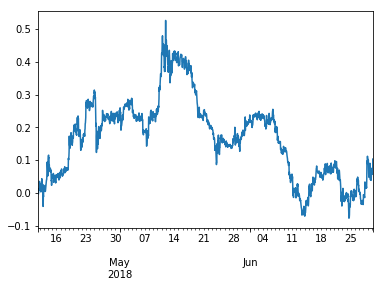

In [468]:
asset_data[:,:,'diff'].mean(axis=1).cumsum().plot()

In [498]:
model=RPG_Crypto_portfolio(action_size=2,feature_number=asset_data.shape[2],learning_rate=1e-4)
model.init_model()

In [499]:
# model.load_model(model_path='./PortfolioTrading/RPG_Portfolio_bat')

In [500]:
normalize_length=10
train_length=1500
batch_size=60
c=1e-5
epoch=30
train_r=[]
train_mean_r=[]
test_r=[]
test_mean_r=[]
model.restore_buffer()
for e in range(epoch):
    train_reward=[]
    test_reward=[]
    test_actions=[]
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(normalize_length,train_length):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        data=asset_data[:,t-normalize_length+1:t+1,:].values
        next_state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=True,prob=False,drop=1.0)
        r=asset_data[:,:,'diff'].iloc[t].values*action[:,0]-c*np.abs(previous_action-action[:,0])
        model.save_transation(a=action,r=r,s_next=next_state)
        previous_action=action[:,0]
        train_reward.append(r)
        if t%batch_size==0:
            model.train(drop=0.8)
            model.restore_buffer()
    model.restore_buffer()
    print(e,'train_reward',np.sum(np.mean(train_reward,axis=1)),np.mean(train_reward))
    train_r.append(np.sum(np.mean(train_reward,axis=1)))
    train_mean_r.append(np.mean(train_reward))
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(train_length,asset_data.shape[1]):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=False,prob=False,drop=1.0)
        r=asset_data[:,:,'diff'].iloc[t].values*action[:,0]-c*np.abs(previous_action-action[:,0])
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action[:,0]
        if t % batch_size==0:
            model.restore_buffer()
    print(e,'test_reward',np.sum(np.mean(test_reward,axis=1)),np.mean(test_reward))
    test_r.append(np.sum(np.mean(test_reward,axis=1)))
    test_mean_r.append(np.mean(test_reward))
    model.restore_buffer()
    if np.sum(np.mean(test_reward,axis=1))>0.45: break
model.restore_buffer()

0 train_reward -0.1616915400888754 -0.00010851781214018485
0 test_reward 0.1075227679378066 0.0002609775920820549
1 train_reward -0.37281094856014485 -0.00025020869030882196
1 test_reward 0.15049735724563168 0.0003652848476835721
2 train_reward -0.030119721286631936 -2.021457804471945e-05
2 test_reward 0.19023555770197959 0.00046173679053878545
3 train_reward 0.2045749140184064 0.00013729860001235325
3 test_reward 0.2056867849100358 0.0004992397691991159
4 train_reward -0.15941956360894033 -0.00010699299571069821
4 test_reward 0.27458377535115075 0.0006664654741532785
5 train_reward 0.19160555615391495 0.0001285943329892046
5 test_reward 0.27307337314212304 0.0006627994493740851
6 train_reward -0.10130625033362717 -6.799077203599139e-05
6 test_reward 0.34058970452062864 0.0008266740400986131
7 train_reward -0.0905996759217236 -6.080515162531791e-05
7 test_reward 0.33343919102487696 0.0008093184248176624
8 train_reward 0.17477251955891432 0.00011729699299255993
8 test_reward 0.345638055

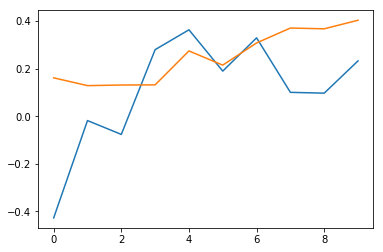

In [472]:
plt.plot(train_r)
plt.plot(test_r)

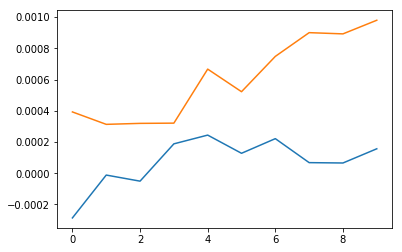

In [473]:
plt.plot(train_mean_r)
plt.plot(test_mean_r)

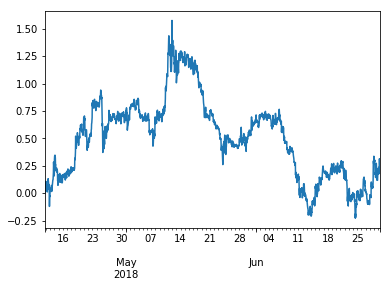

In [474]:
asset_data[:,:,'diff'].sum(axis=1).cumsum().plot()

In [475]:
train_reward=np.mean(np.array(train_reward),axis=1)

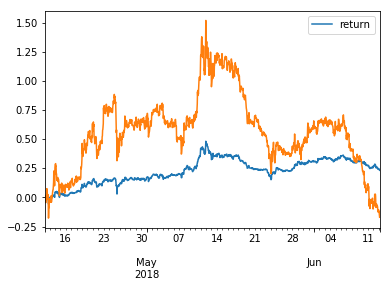

In [476]:
pd.DataFrame(train_reward,index=asset_data[:,normalize_length:train_length,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,normalize_length:train_length,'diff'].sum(axis=1).cumsum().plot()

In [477]:
test_reward=np.mean(test_reward,axis=1)

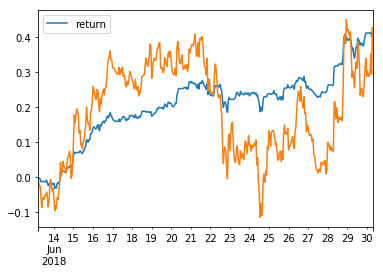

In [478]:
pd.DataFrame(test_reward,index=asset_data[:,train_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,train_length:,'diff'].sum(axis=1).cumsum().plot()

In [479]:
def maxdrawdown(arr):
    i = np.argmax((np.maximum.accumulate(arr) - arr))  # end of the period
    j = np.argmax(arr[:i])  # start of period
    return (arr[j] - arr[i])

def max_arbitrage(arr):
    return maxdrawdown(arr[::-1])

In [480]:
test_actions=np.array(test_actions)[:,:,0]

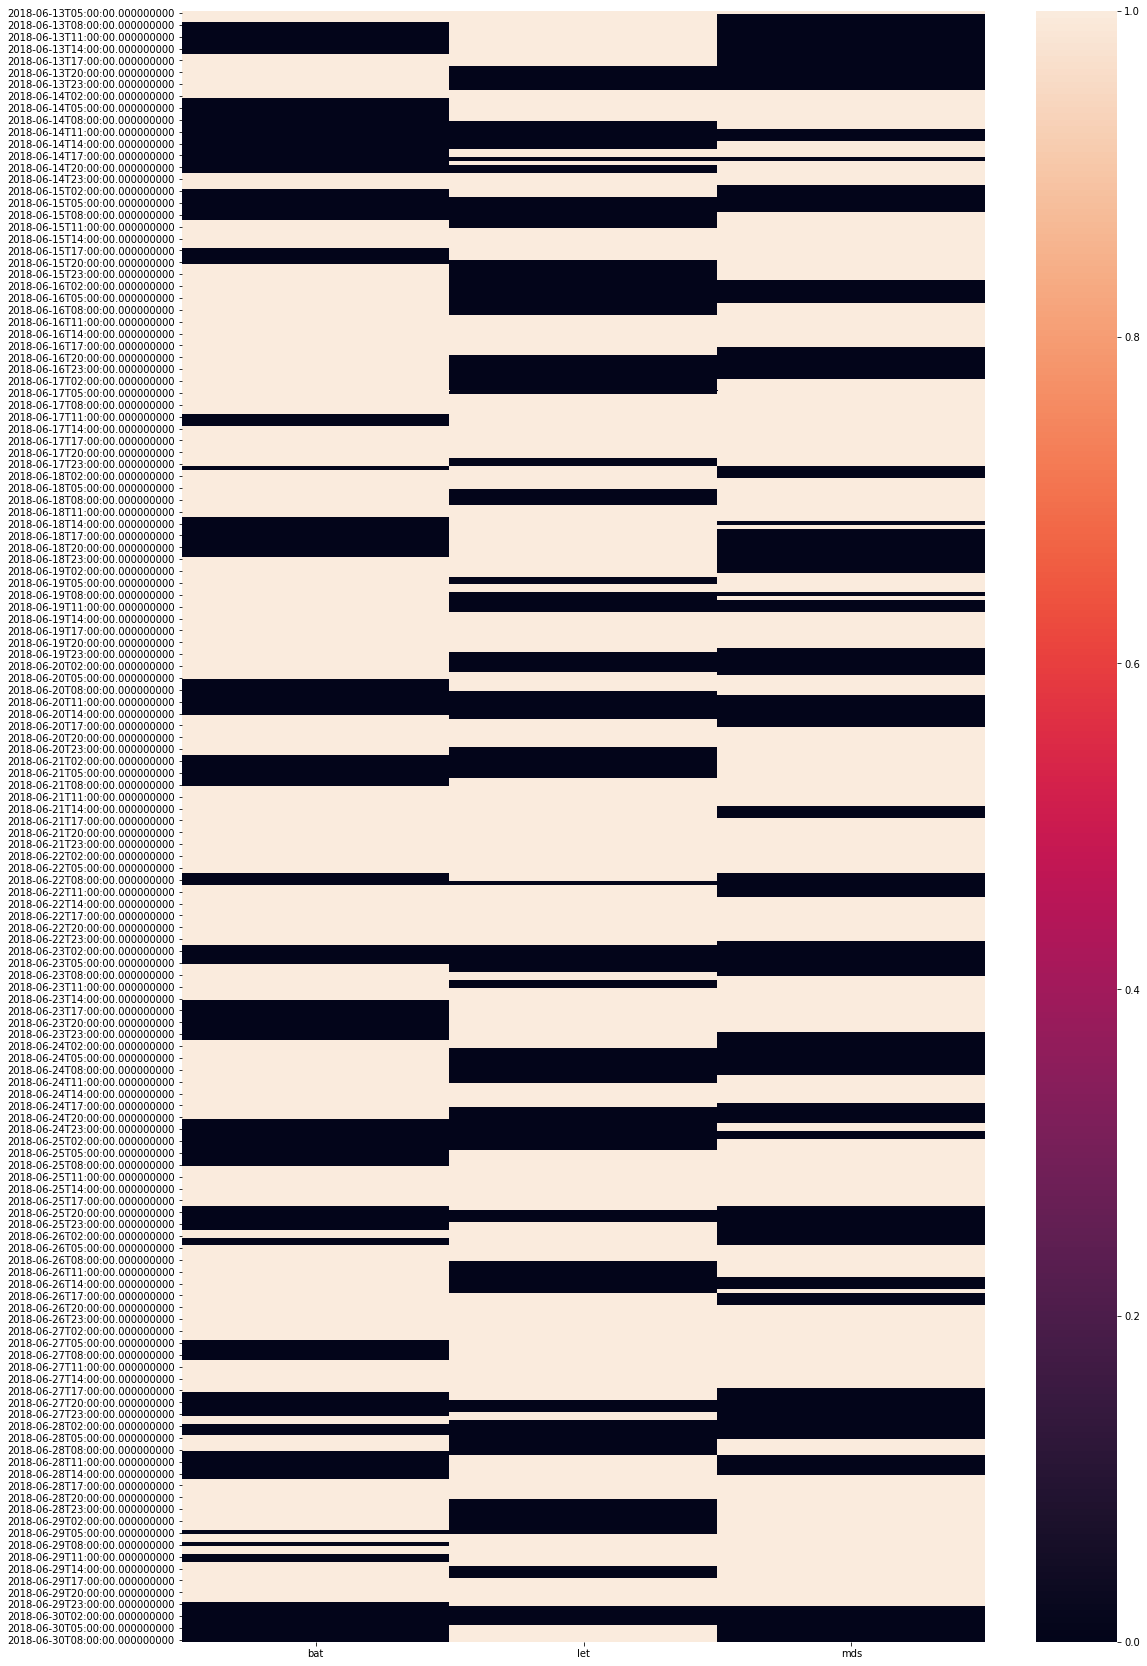

In [481]:
test_action_df=pd.DataFrame(test_actions,index=asset_data[:,train_length:,'diff'].index,columns=list(asset_data.items))
plt.figure(figsize=(18,30))
sns.heatmap(test_action_df)

In [482]:
test_length=asset_data.shape[1]-train_length

In [488]:
def backtest(asset_data, model, test_length,batch_size=60, normalize_length=10, c=1e-4):
    test_reward = []
    test_actions = []
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(asset_data.shape[1]-test_length,asset_data.shape[1]):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=False,prob=False,drop=1.0)
        r=asset_data[:,:,'diff'].iloc[t].values*action[:,0]-c*np.abs(previous_action-action[:,0])
        test_reward.append(r)
        test_actions.append(action)
        previous_action=action[:,0]
        if t % batch_size==0:
            model.restore_buffer()
    model.restore_buffer()
    print('back test_reward', np.sum(np.mean(test_reward,axis=1)))
    return np.sum(np.mean(test_reward,axis=1)),test_actions,np.mean(test_reward,axis=1)

In [490]:
_,test_actions,test_reward=backtest(asset_data,model,test_length=test_length,batch_size=60)

back test_reward 0.3993677653786222


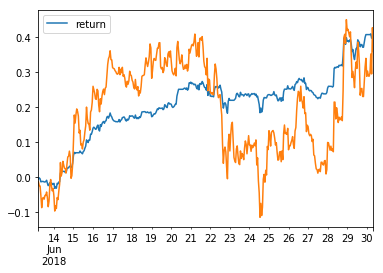

In [491]:
pd.DataFrame(test_reward,index=asset_data[:,-test_length:,'diff'].index,columns=['return']).cumsum().plot()
asset_data[:,-test_length:,'diff'].sum(axis=1).cumsum().plot()

In [492]:
max_arbitrage(asset_data[:,-test_length:,'diff'].mean(axis=1).cumsum())

0.18827403

In [493]:
np.abs(test_action_df.shift(1)-test_action_df).sum()

bat    45.0
let    52.0
mds    49.0
dtype: float64

In [494]:
def real_trade(asset_data,model, assets, normalize_length=10,batch_size=30, debug=True):
    test_reward = []
    test_actions = []
    model.restore_buffer()
    previous_action=np.zeros(asset_data.shape[0])
    for t in range(asset_data.shape[1]-batch_size,asset_data.shape[1]):
        data=asset_data[:,t-normalize_length:t,:].values
        state=((data-np.mean(data,axis=1,keepdims=True))/(np.std(data,axis=1,keepdims=True)+1e-5))[:,-1,:]
        model.save_current_state(s=state)
        action=model.trade(train=False,prob=False,drop=1.0)
    action = list(zip(assets, action[:,0]))
#     action = sorted(action, key=lambda x: x[1])
    print('predict action', action)
    return action

In [495]:
real_trade(asset_data,model,assets=assets)

predict action [('bat', 0.0), ('let', 1.0), ('mds', 0.0)]


[('bat', 0.0), ('let', 1.0), ('mds', 0.0)]

In [696]:
model.save_model('./PortfolioTrading/RPG_Portfolio_shareV')